# Wrangling and Analyze Data: WeRateDogs Twitter Archive

## Introduction

Real-world data rarely comes clean. Using Python and its libraries, we gathered data from a variety of sources and in a variety of formats, assessed its quality and tidiness, then cleaned it. In this notebook, I documented my data wrangling efforts and showed them through analyses and visualizations.

The used data is the tweet archive of Twitter user @dog_rates, also known as WeRateDogs. WeRateDogs is a Twitter account that rates people's dogs with a humorous comment about the dog. These ratings almost always have a denominator of 10. The numerators, though? Almost always greater than 10. 11/10, 12/10, 13/10, etc.

After importing the necessary libraries, we will begin wrangling and analyzing the data. The process will be divided into several steps:

1. Gather the necessary data from different file formats and sources, and load it into dataframes.
2. Assess the data to find any quality and tidiness issues within the dataframes.
3. Clean the data and fix the identifies quality and tidiness related issues.
4. Store the clean data into a new dataframe.
5. Analyze and visualize data to extract results and conclusions.

In [26]:
# Importing the necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import os
import requests as req
import json
import tweepy
import sqlalchemy
import seaborn as sns

## Data Gathering

In this step, we start the data wrangling process by gathering the necessary data using different formats. 
- The first dataset is the WeRateDogs Twitter archive data (twitter_archive_enhanced.csv), which was provided by Udacity and uploaded to the notebook manually and its format is CSV (comma-separated values). 
- The second dataset is the tweet image prediction (image_predictions.tsv), which was downloaded programmatically using the Requests library and its format is TSV (tab-separated values). 
- The third dataset is the additional data via the Twitter API (tweet_json.txt), which was provided by Udacity and uploaded to the notebook manually and its format is TXT (text file).

1. Directly download the WeRateDogs Twitter archive data (twitter_archive_enhanced.csv)

In [2]:
twitter_archive = pd.read_csv('twitter-archive-enhanced.csv')
twitter_archive.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


2. Use the Requests library to download the tweet image prediction (image_predictions.tsv)

In [3]:
import requests
import os

# Make directory if it doesn't already exist
folder_name = 'image_predictions'
if not os.path.exists(folder_name):
    os.makedirs(folder_name)

url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
response = requests.get(url)

with open(os.path.join(folder_name, url.split('/')[-1]), mode='wb') as file:
    file.write(response.content)
    
#Import the tweet image predictions TSV file into a DataFrame
image_prediction = pd.read_csv(folder_name + '/image-predictions.tsv', sep='\t')
image_prediction.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


3. Use the Tweepy library to query additional data via the Twitter API (tweet_json.txt)

Since I couldn't access Twitter API, I will be uploading the `tweet-json.txt` JSON text file manually that Udacity provided for this project. The text file contains a different object for each line, so we need to read each JSON object one-by-one, extract the important information, and store this data in a DataFrame.

In [4]:
tweet_data = pd.DataFrame(columns = ['tweet_id', 'retweet_count', 'favorite_count'])

# open the TXT file programmatically
with open('tweet-json.txt') as tweet_file:
    for line in tweet_file:
        # load its contents line by line
        tweet = json.loads(line)
        if ((tweet['in_reply_to_status_id'] == None) & (tweet['in_reply_to_user_id'] == None)): # if it's not a retweet or reply
            id_string = tweet['id_str']
            retweet_count = tweet['retweet_count']
            favorite_count = tweet['favorite_count']
            
            # store the additional needed information into a dataframe
            tweet_data = tweet_data.append({'tweet_id' : id_string,
                                                            'retweet_count' : retweet_count,
                                                            'favorite_count' : favorite_count}, 
                                                           ignore_index = True)
        else:
            continue

In [5]:
tweet_data.head()

,tweet_id,retweet_count,favorite_count
0,892420643555336193,8853,39467
1,892177421306343426,6514,33819
2,891815181378084864,4328,25461
3,891689557279858688,8964,42908
4,891327558926688256,9774,41048


## Assessing Data

In this step, we continue the data wrangling process by assesing the data both visually and programatically. This process would help us in detecting quality and tidiness issues in our data.

### Visual Assessment

> **WeRateDogs Twitter archive data:** `twitter_archive`

In [6]:
# View a sample of the data
twitter_archive.sample(10)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
28,886680336477933568,NaN,NaN,2017-07-16 20:14:00 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Derek. He's late for a dog meeting. 13...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/886680336...,13,10,Derek,None,None,None,None
544,805932879469572096,NaN,NaN,2016-12-06 00:32:26 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Major. He put on a tie for his first r...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/805932879...,12,10,Major,None,None,None,None
248,845397057150107648,NaN,NaN,2017-03-24 22:08:59 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Say hello to Mimosa. She's an emotional suppor...,NaN,NaN,NaN,"https://www.gofundme.com/help-save-a-pup,https...",13,10,Mimosa,doggo,None,None,None
648,793120401413079041,NaN,NaN,2016-10-31 16:00:13 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Robin. She's desperately trying to do ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/793120401...,11,10,Robin,None,None,None,None
147,863432100342583297,NaN,NaN,2017-05-13 16:33:49 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Belle. She's never been more pupset. E...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/863432100...,12,10,Belle,None,None,None,None
1298,707741517457260545,NaN,NaN,2016-03-10 01:35:01 +0000,"<a href=""http://twitter.com/download/iphone"" r...",When your roommate eats your leftover Chili's ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/707741517...,10,10,None,None,None,None,None
682,788552643979468800,NaN,NaN,2016-10-19 01:29:35 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: Say hello to mad pupper. You kn...,7.363926e+17,4.196984e+09,2016-05-28 03:04:00 +0000,"https://vine.co/v/iEggaEOiLO3,https://vine.co/...",13,10,mad,None,None,pupper,None
553,804026241225523202,NaN,NaN,2016-11-30 18:16:08 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Bo. He's going to make me cry. 13/10 p...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/804026241...,13,10,Bo,None,None,None,None
1918,674271431610523648,NaN,NaN,2015-12-08 16:56:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...","""AT DAWN, WE RIDE""\n10/10 for both dogs https:...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/674271431...,10,10,None,None,None,None,None
2254,667782464991965184,NaN,NaN,2015-11-20 19:12:01 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Super rare dog. Endangered (?). Thinks it's fu...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/667782464...,9,10,None,None,None,None,None


In [7]:
# View a sample of the text in the data
twitter_archive['text'].sample(10)

1112    This is Hermione. Her face is as old as time. ...
1284    Meet Bear. He's a Beneboop Cumberclap. Extreme...
1277    This is Klevin. He's addicted to sandwiches (y...
1218    This is Curtis. He's an Albino Haberdasher. Te...
855     This is Aubie. He has paws for days. Nibbling ...
340     RT @dog_rates: This is Logan, the Chow who liv...
962     Meet Milo. He hauled ass until he ran out of t...
314     We only rate dogs. Please don't send in any no...
321     This is Wilson. He's aware that he has somethi...
761     This is Stanley. He has too much skin. Isn't h...
Name: text, dtype: object

> **Tweet image prediction data:** `image_prediction`

In [8]:
# View a sample of data
image_prediction.sample(10)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
1662,811985624773361665,https://pbs.twimg.com/media/C0TAnZIUAAAADKs.jpg,1,Staffordshire_bullterrier,0.610573,True,French_bulldog,0.159935,True,doormat,0.058672,False
1788,829861396166877184,https://pbs.twimg.com/media/C4RCiIHWYAAwgJM.jpg,1,Border_terrier,0.394486,True,Staffordshire_bullterrier,0.376574,True,American_Staffordshire_terrier,0.031292,True
522,676582956622721024,https://pbs.twimg.com/media/CWO0m8tUwAAB901.jpg,1,seat_belt,0.790028,False,Boston_bull,0.196307,True,French_bulldog,0.012429,True
1283,750429297815552001,https://pbs.twimg.com/media/CmoPdmHW8AAi8BI.jpg,1,golden_retriever,0.964929,True,Labrador_retriever,0.011584,True,refrigerator,0.007499,False
1304,753294487569522689,https://pbs.twimg.com/media/CnQ9Vq1WEAEYP01.jpg,1,chow,0.194773,True,monitor,0.102305,False,Siberian_husky,0.086855,True
582,678798276842360832,https://pbs.twimg.com/media/CWuTbAKUsAAvZHh.jpg,1,Airedale,0.583122,True,silky_terrier,0.129567,True,Lakeland_terrier,0.094727,True
1070,716285507865542656,https://pbs.twimg.com/media/CfDB3aJXEAAEZNv.jpg,1,Yorkshire_terrier,0.430420,True,silky_terrier,0.196769,True,cairn,0.072676,True
1542,791312159183634433,https://pbs.twimg.com/media/CvtONV4WAAAQ3Rn.jpg,4,miniature_pinscher,0.892925,True,toy_terrier,0.095524,True,Doberman,0.003544,True
1735,821765923262631936,https://pbs.twimg.com/media/C2d_vnHWEAE9phX.jpg,1,golden_retriever,0.980071,True,Labrador_retriever,0.008758,True,Saluki,0.001806,True
2004,877316821321428993,https://pbs.twimg.com/media/DCza_vtXkAQXGpC.jpg,1,Saluki,0.509967,True,Italian_greyhound,0.090497,True,golden_retriever,0.079406,True


> **Additional data via the Twitter API:** `tweet_data`

In [9]:
# View a sample of data
tweet_data.sample(10)

,tweet_id,retweet_count,favorite_count
1150,717841801130979328,670,2660
829,762464539388485633,4839,11503
479,812781120811126785,2191,8380
1883,673583129559498752,403,1273
46,882992080364220416,4122,24445
1265,707315916783140866,727,2698
1510,688116655151435777,888,3093
1254,707969809498152960,1097,2941
895,754449512966619136,846,4147
1187,713900603437621249,829,3062


# Programmatic Assessment

> **WeRateDogs Twitter archive data:** `twitter_archive`

In [10]:
# Display information
twitter_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [11]:
# Find the sum of null values
twitter_archive.isnull().sum()

tweet_id                         0
in_reply_to_status_id         2278
in_reply_to_user_id           2278
timestamp                        0
source                           0
text                             0
retweeted_status_id           2175
retweeted_status_user_id      2175
retweeted_status_timestamp    2175
expanded_urls                   59
rating_numerator                 0
rating_denominator               0
name                             0
doggo                            0
floofer                          0
pupper                           0
puppo                            0
dtype: int64

In [12]:
# Check for duplicates
twitter_archive[twitter_archive.tweet_id.duplicated()]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo


Great! no duplicated values

In [13]:
# Check the rating values for the nominator
twitter_archive['rating_numerator'].value_counts()

12      558
11      464
10      461
13      351
9       158
8       102
7        55
14       54
5        37
6        32
3        19
4        17
1         9
2         9
420       2
0         2
15        2
75        2
80        1
20        1
24        1
26        1
44        1
50        1
60        1
165       1
84        1
88        1
144       1
182       1
143       1
666       1
960       1
1776      1
17        1
27        1
45        1
99        1
121       1
204       1
Name: rating_numerator, dtype: int64

In [14]:
# Check the rating values for the denominator
twitter_archive['rating_denominator'].value_counts()

10     2333
11        3
50        3
80        2
20        2
2         1
16        1
40        1
70        1
15        1
90        1
110       1
120       1
130       1
150       1
170       1
7         1
0         1
Name: rating_denominator, dtype: int64

In [15]:
# Check unique names in data
twitter_archive['name'].unique()

array(['Phineas', 'Tilly', 'Archie', 'Darla', 'Franklin', 'None', 'Jax',
       'Zoey', 'Cassie', 'Koda', 'Bruno', 'Ted', 'Stuart', 'Oliver', 'Jim',
       'Zeke', 'Ralphus', 'Canela', 'Gerald', 'Jeffrey', 'such', 'Maya',
       'Mingus', 'Derek', 'Roscoe', 'Waffles', 'Jimbo', 'Maisey', 'Lilly',
       'Earl', 'Lola', 'Kevin', 'Yogi', 'Noah', 'Bella', 'Grizzwald',
       'Rusty', 'Gus', 'Stanley', 'Alfy', 'Koko', 'Rey', 'Gary', 'a',
       'Elliot', 'Louis', 'Jesse', 'Romeo', 'Bailey', 'Duddles', 'Jack',
       'Emmy', 'Steven', 'Beau', 'Snoopy', 'Shadow', 'Terrance', 'Aja',
       'Penny', 'Dante', 'Nelly', 'Ginger', 'Benedict', 'Venti', 'Goose',
       'Nugget', 'Cash', 'Coco', 'Jed', 'Sebastian', 'Walter', 'Sierra',
       'Monkey', 'Harry', 'Kody', 'Lassie', 'Rover', 'Napolean', 'Dawn',
       'Boomer', 'Cody', 'Rumble', 'Clifford', 'quite', 'Dewey', 'Scout',
       'Gizmo', 'Cooper', 'Harold', 'Shikha', 'Jamesy', 'Lili', 'Sammy',
       'Meatball', 'Paisley', 'Albus', 'Neptune', '

In [16]:
twitter_archive[['doggo', 'floofer', 'pupper', 'puppo']].sample(10)

,doggo,floofer,pupper,puppo
1111,None,None,None,None
900,None,None,None,None
360,None,None,None,None
1542,None,None,None,None
872,None,None,None,None
1896,None,None,None,None
972,None,None,None,None
1722,None,None,None,None
1651,None,None,None,None
1751,None,None,None,None


In [17]:
# Count the number of retweets in the data
twitter_archive['text'].str.startswith('RT @dog_rates:').sum()

156

### Quality issues

1. Missing values in columns from `in_reply_to_status_id`, `in_reply_to_user_id`, `retweeted_status_id`, `retweeted_status_user_id`, `retweeted_status_timestamp`, and `expanded_urls`.

2. The columns `rating_numerator` and `rating_denominator` have some incosistent values in the numerator and denominator, such as numerators < 10 and denominators other than 10.

3. The column `timestamps` is in string instead of DateTime data type.

4. Error in dog names, such as (actually, officially, O, a, not, his, etc).

5. The columns which have missing values in `doggo`, `floofer`, `pupper`, and `puppo` has None instead of NaN.

6. The text contains some 156 retweets which begins with `RT @dog_rates:` and this is irrelvent to our case since we need original tweets for the dog ratings.


### Tidiness issues

1. The columns `doggo`, `floofer`, `pupper`, and `puppo` are all dog stages and should be merged into one column called `dog_stages`. This could reduce the dimensionality of the data.

> **Tweet image prediction data:** `image_prediction`

In [18]:
# Display information
image_prediction.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [19]:
# Find the sum of null values
image_prediction.isnull().sum()

tweet_id    0
jpg_url     0
img_num     0
p1          0
p1_conf     0
p1_dog      0
p2          0
p2_conf     0
p2_dog      0
p3          0
p3_conf     0
p3_dog      0
dtype: int64

As we can see, there aren't null values in the data

In [20]:
# Check the values of img_num
image_prediction['img_num'].value_counts()

1    1780
2     198
3      66
4      31
Name: img_num, dtype: int64

In [21]:
# Check dog names
image_prediction[['p1', 'p2', 'p3']].sample(10)

,p1,p2,p3
1610,cocker_spaniel,Dandie_Dinmont,English_setter
1955,bull_mastiff,French_bulldog,Staffordshire_bullterrier
1110,Siamese_cat,pug,quilt
1983,Shetland_sheepdog,collie,Pomeranian
1546,cocker_spaniel,Irish_setter,miniature_poodle
1906,barbell,dumbbell,go-kart
378,Airedale,brown_bear,Chesapeake_Bay_retriever
1715,standard_poodle,toy_poodle,Tibetan_terrier
1646,Airedale,cocker_spaniel,Irish_terrier
238,jack-o'-lantern,Chesapeake_Bay_retriever,Labrador_retriever


### Quality issues

1. The predicted dog species in columns `p1`, `p2`, and `p3` are not consistent since some species start with a capital letter and some start with a small letter.

2. The space is represted by an underscore `_` in `p1`, `p2`, and `p3`.

3. There are some missing images since `twitter_archive` has 2356 tweets and `image_prediction` has 2075 image predictions.

### Tidiness issues

1. The `image_prediction` dataframe should be merged with `twitter_archive` on the `tweet_id`.

> **Additional data via the Twitter API:** `tweet_data`

In [22]:
# Display information
tweet_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2276 entries, 0 to 2275
Data columns (total 3 columns):
tweet_id          2276 non-null object
retweet_count     2276 non-null object
favorite_count    2276 non-null object
dtypes: object(3)
memory usage: 53.4+ KB


In [23]:
# Check for duplicates
tweet_data[tweet_data.tweet_id.duplicated()]

,tweet_id,retweet_count,favorite_count


In [24]:
# Find the sum of null values
tweet_data.isnull().sum()

tweet_id          0
retweet_count     0
favorite_count    0
dtype: int64

Great! no duplicated of missing values.

### Quality issues

1. The data type of `tweet_id` is string and it should be compatible with `tweet_id` data type in `twitter_archive` dataframe.
2. There are some missing tweets since `twitter_archive` contains 2356 tweets and `tweet_data` contains 2276 tweets.

### Tidiness issues

1. The `tweet_data` dataframe should be merged with `twitter_archive` on `tweet_id`.

## Cleaning Data

In this step and after assesing the data, we need to fix the identified quality and tidiness issues in all the dataframes. This is a crucial step for accuracy and drawing conclusions. We began by making a copy of the original pieces of data to perform the cleaning step on them. We followed the define-code-test framework, which defines the issue and its solution, program the solution, then view and test the outcome.

In [25]:
# Make copies of original pieces of data
twitter_archive_clean = twitter_archive.copy()
image_prediction_clean = image_prediction.copy()
tweet_data_clean = tweet_data.copy()

## Cleaning `twitter_archive` dataset

### Quality Issues

#### Issue #1: 
Missing values in columns from `in_reply_to_status_id`, `in_reply_to_user_id`, `retweeted_status_id`, `retweeted_status_user_id`, `retweeted_status_timestamp`, and `expanded_urls`.

#### Solution:

Drop columns `in_reply_to_status_id`, `in_reply_to_user_id`, `retweeted_status_id`, `retweeted_status_user_id`, `retweeted_status_timestamp`, and `expanded_urls` since they are irrelevant to our analysis.

#### Code

In [26]:
twitter_archive_clean.drop(columns= ['in_reply_to_status_id', 'in_reply_to_user_id', 'retweeted_status_id', 'retweeted_status_user_id', 'retweeted_status_timestamp', 'expanded_urls'], inplace= True)


#### Test

In [27]:
twitter_archive_clean.columns

Index(['tweet_id', 'timestamp', 'source', 'text', 'rating_numerator',
       'rating_denominator', 'name', 'doggo', 'floofer', 'pupper', 'puppo'],
      dtype='object')

In [28]:
twitter_archive_clean.head()

,tweet_id,timestamp,source,text,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,13,10,Phineas,None,None,None,None
1,892177421306343426,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,13,10,Tilly,None,None,None,None
2,891815181378084864,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,12,10,Archie,None,None,None,None
3,891689557279858688,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,13,10,Darla,None,None,None,None
4,891327558926688256,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,12,10,Franklin,None,None,None,None


#### Issue #2:
The columns `rating_numerator` and `rating_denominator` have some incosistent values in the numerator and denominator, such as numerators < 10 and denominators other than 10.

#### Solution:
Drop rows with numerator values less than 10 and denominator values not equal to 10

#### Code

In [29]:
# Create a boolean mask indicating which rows to drop
mask = (twitter_archive_clean['rating_numerator'] < 10) | (twitter_archive_clean['rating_denominator'] != 10)

# Use the mask to drop the rows
twitter_archive_clean.drop(twitter_archive_clean[mask].index, inplace=True)

#### Test

In [30]:
twitter_archive_clean['rating_numerator'].value_counts()

12      558
11      463
10      461
13      351
14       54
420       2
75        2
15        2
1776      1
666       1
182       1
27        1
26        1
17        1
Name: rating_numerator, dtype: int64

In [31]:
twitter_archive_clean['rating_denominator'].value_counts()

10    1899
Name: rating_denominator, dtype: int64

#### Issue #3:
The column `timestamps` is in string instead of DateTime data type.

#### Solution:
Convert `timestamp` data type to DateTime instead of string.

#### Code

In [32]:
twitter_archive_clean['timestamp'] = pd.to_datetime(twitter_archive_clean['timestamp'])

#### Test

In [33]:
print(twitter_archive_clean.timestamp.dtype)

datetime64[ns]


In [34]:
twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1899 entries, 0 to 2350
Data columns (total 11 columns):
tweet_id              1899 non-null int64
timestamp             1899 non-null datetime64[ns]
source                1899 non-null object
text                  1899 non-null object
rating_numerator      1899 non-null int64
rating_denominator    1899 non-null int64
name                  1899 non-null object
doggo                 1899 non-null object
floofer               1899 non-null object
pupper                1899 non-null object
puppo                 1899 non-null object
dtypes: datetime64[ns](1), int64(3), object(7)
memory usage: 178.0+ KB


#### Issue #4:
Error in dog names, such as (actually, officially, O, a, not, his, etc).

#### Solution:
Store the names in a list and replace them in the dataframe into `None`.

#### Code

In [35]:
dog_names_to_change = ['infuriating', 'just', 'life', 'light', 'mad', 'my', 'not', 'officially', 'old', 'one', 'quite', 'space', 
       'such', 'the', 'this', 'unacceptable', 'very', 'a', 'an', 'actually', 'his', 'O']

twitter_archive_clean['name'] = twitter_archive['name'].replace(dog_names_to_change, value= None)

#### Test

In [36]:
twitter_archive_clean['name'].value_counts()

None         617
Charlie       12
Oliver        11
Cooper        10
Lucy          10
Tucker         9
Bo             9
Lola           8
Penny          8
Winston        8
Sadie          7
Milo           6
Leo            6
Koda           6
Bailey         6
Louis          6
Daisy          6
Jack           6
Toby           5
Finn           5
Jax            5
Jeffrey        5
Dave           5
Stanley        5
Sammy          5
Scout          5
Oscar          5
Oakley         5
Buddy          5
Rusty          5
            ... 
Dutch          1
Rambo          1
Emma           1
Stefan         1
Chef           1
Eriq           1
Rilo           1
Beebop         1
Grizzie        1
Benedict       1
Kanu           1
Cedrick        1
Burt           1
Bronte         1
Strudel        1
Alexander      1
Shnuggles      1
Hall           1
Sonny          1
Schnozz        1
Eugene         1
Skittle        1
Brat           1
Gustav         1
Rey            1
Sully          1
Harlso         1
Alejandro     

#### Issue #5:
The columns which have missing values in `doggo`, `floofer`, `pupper`, and `puppo` has None instead of NaN.

#### Solution:
Replace 'None' string values in any of these four columns with NaN.

#### Code

In [37]:
twitter_archive_clean.doggo = twitter_archive_clean.doggo.apply(lambda entry: pd.np.nan if entry == 'None' else entry)
twitter_archive_clean.floofer = twitter_archive_clean.floofer.apply(lambda entry: pd.np.nan if entry == 'None' else entry)
twitter_archive_clean.pupper = twitter_archive_clean.pupper.apply(lambda entry: pd.np.nan if entry == 'None' else entry)
twitter_archive_clean.puppo = twitter_archive_clean.puppo.apply(lambda entry: pd.np.nan if entry == 'None' else entry)

#### Test

In [38]:
twitter_archive_clean[['doggo', 'floofer', 'pupper', 'puppo']].sample(5)

,doggo,floofer,pupper,puppo
1482,NaN,NaN,NaN,NaN
441,NaN,NaN,NaN,NaN
278,NaN,NaN,NaN,NaN
935,NaN,NaN,NaN,NaN
779,NaN,NaN,NaN,NaN


#### Issue #6:
The text contains some 156 retweets which begins with `RT @dog_rates:` and this is irrelvent to our case since we need original tweets for the dog ratings.

#### Solution:
Drop the rows with text that begins with `RT @dog_rates:`.

#### Code

In [39]:
# Use the str.startswith() method to create a boolean mask indicating which rows to drop
mask = twitter_archive_clean['text'].str.startswith('RT @dog_rates:')

# Use the mask to drop the rows
twitter_archive_clean.drop(twitter_archive_clean[mask].index, inplace=True)

#### Test

In [40]:
# Count the number of retweets in the data
twitter_archive_clean['text'].str.startswith('RT @dog_rates:').sum()

0

### Tidiness Issues:

#### Issue #1:
The columns `doggo`, `floofer`, `pupper`, and `puppo` are all dog stages and should be merged into one column called `dog_stages`. This could reduce the dimensionality of the data.

#### Solution:
Create a column called `dog_stages` that has the values `doggo`, `floofer`, `pupper`, `puppo`, and `multiple` when the dog has more than one stage. Then drop the columns `doggo`, `floofer`, `pupper`, and `puppo`.

#### Code

In [41]:
def write_dog_stage(dog_stage):
    total_num_of_stages = dog_stage[['doggo', 'floofer', 'pupper', 'puppo']].count().sum()
    
    if (total_num_of_stages > 1):
        return 'multiple'
    else:
        if (dog_stage.doggo == dog_stage.doggo):
            return 'doggo'
        elif (dog_stage.floofer == dog_stage.floofer):
            return 'floofer'
        elif (dog_stage.pupper == dog_stage.pupper):
            return 'pupper'
        elif (dog_stage.puppo == dog_stage.puppo):
            return 'puppo'
    return pd.np.nan

twitter_archive_clean['dog_stage'] = twitter_archive_clean.apply(lambda x: write_dog_stage(x), axis = 1)
twitter_archive_clean.drop(columns= ['doggo', 'floofer', 'pupper', 'puppo'], axis= 1, inplace= True)

#### Test

In [42]:
twitter_archive_clean.sample(5)

,tweet_id,timestamp,source,text,rating_numerator,rating_denominator,name,dog_stage
1900,674664755118911488,2015-12-09 18:59:46,"<a href=""http://twitter.com/download/iphone"" r...",This is Rodman. He's getting destroyed by the ...,10,10,Rodman,NaN
1263,710117014656950272,2016-03-16 14:54:24,"<a href=""http://twitter.com/download/iphone"" r...",This pupper got her hair chalked for her birth...,11,10,None,pupper
1286,708400866336894977,2016-03-11 21:15:02,"<a href=""http://vine.co"" rel=""nofollow"">Vine -...",RT if you are as ready for summer as this pup ...,12,10,None,NaN
327,833732339549220864,2017-02-20 17:37:34,"<a href=""http://twitter.com/download/iphone"" r...",RT @rolltidered: This is Gabby. Now requests t...,12,10,Gabby,NaN
844,766693177336135680,2016-08-19 17:47:52,"<a href=""http://twitter.com/download/iphone"" r...",This is Brudge. He's a Doberdog. Going to be h...,11,10,Brudge,NaN


## Cleaning `image_prediction` dataset

### Quality Issues

#### Issue #1:
The predicted dog species in columns `p1`, `p2`, and `p3` are not consistent since some species start with a capital letter and some start with a small letter.

#### Solution:
Capitalize the first letter of each dog race in `p1`, `p2`, and `p3`.

#### Code

In [43]:
# Capitalize the first letter of each dog race
image_prediction_clean.p1 = image_prediction_clean.p1.str.title()
image_prediction_clean.p2 = image_prediction_clean.p2.str.title()
image_prediction_clean.p3 = image_prediction_clean.p3.str.title()

#### Test

In [44]:
image_prediction_clean[['p1', 'p2', 'p3']]

,p1,p2,p3
0,Welsh_Springer_Spaniel,Collie,Shetland_Sheepdog
1,Redbone,Miniature_Pinscher,Rhodesian_Ridgeback
2,German_Shepherd,Malinois,Bloodhound
3,Rhodesian_Ridgeback,Redbone,Miniature_Pinscher
4,Miniature_Pinscher,Rottweiler,Doberman
5,Bernese_Mountain_Dog,English_Springer,Greater_Swiss_Mountain_Dog
6,Box_Turtle,Mud_Turtle,Terrapin
7,Chow,Tibetan_Mastiff,Fur_Coat
8,Shopping_Cart,Shopping_Basket,Golden_Retriever
9,Miniature_Poodle,Komondor,Soft-Coated_Wheaten_Terrier


#### Issue #2:
The space is represted by an underscore `_` in `p1`, `p2`, and `p3`.

#### Solution:
Replace the underscore by an empty space in `p1`, `p2`, and `p3`.

#### Code

In [45]:
# Replace underscores in string with empty space character
image_prediction_clean.p1 = image_prediction_clean.p1.str.replace('_', ' ')
image_prediction_clean.p2 = image_prediction_clean.p2.str.replace('_', ' ')
image_prediction_clean.p3 = image_prediction_clean.p3.str.replace('_', ' ')

#### Test

In [46]:
image_prediction_clean[['p1', 'p2', 'p3']].sample(10)

,p1,p2,p3
370,Pug,Brabancon Griffon,French Bulldog
65,Toy Poodle,Chihuahua,Bluetick
1982,Labrador Retriever,Golden Retriever,Bloodhound
110,Pomeranian,Pekinese,Chihuahua
1762,Labrador Retriever,Golden Retriever,Soft-Coated Wheaten Terrier
1987,Cocker Spaniel,Sussex Spaniel,Standard Poodle
430,Pug,Norwegian Elkhound,Cardigan
1527,Remote Control,Oscilloscope,Golden Retriever
393,Arctic Fox,Golden Retriever,Borzoi
1704,Doberman,Black-And-Tan Coonhound,Miniature Pinscher


#### Issue #3:
There are some missing images since `twitter_archive` has 2356 tweets and `image_prediction` has 2075 image predictions.

#### Solution:
Merge the `image_prediction_clean` and `twitter_archive_clean` datasets on `tweet_id` into a new dataframe.

#### Code

In [47]:
image_archive = pd.merge(twitter_archive_clean, image_prediction_clean, on= 'tweet_id')

#### Test

In [48]:
image_archive.head()

,tweet_id,timestamp,source,text,rating_numerator,rating_denominator,name,dog_stage,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,892420643555336193,2017-08-01 16:23:56,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,13,10,Phineas,NaN,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,1,Orange,0.097049,False,Bagel,0.085851,False,Banana,0.076110,False
1,892177421306343426,2017-08-01 00:17:27,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,13,10,Tilly,NaN,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,Chihuahua,0.323581,True,Pekinese,0.090647,True,Papillon,0.068957,True
2,891815181378084864,2017-07-31 00:18:03,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,12,10,Archie,NaN,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,Chihuahua,0.716012,True,Malamute,0.078253,True,Kelpie,0.031379,True
3,891689557279858688,2017-07-30 15:58:51,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,13,10,Darla,NaN,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,Paper Towel,0.170278,False,Labrador Retriever,0.168086,True,Spatula,0.040836,False
4,891327558926688256,2017-07-29 16:00:24,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,12,10,Franklin,NaN,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,Basset,0.555712,True,English Springer,0.225770,True,German Short-Haired Pointer,0.175219,True


In [49]:
image_archive.shape

(1580, 19)

### Tidiness Issues:

#### Issue #1:
The `tweet_data` dataframe should be merged with `twitter_archive` on `tweet_id`.

#### Solution:
As done on the cell above, the two dataframes are merged to `image_archive` dataset.


## Cleaning `tweet_data` dataset

### Quality Issues

#### Issue #1:
The data type of `tweet_id` is string when it should be integer

#### Solution:
Convert `tweet_id` data type from string to integer

#### Code

In [50]:
tweet_data_clean['tweet_id'] = tweet_data_clean['tweet_id'].astype('int')

#### Test

In [51]:
tweet_data_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2276 entries, 0 to 2275
Data columns (total 3 columns):
tweet_id          2276 non-null int64
retweet_count     2276 non-null object
favorite_count    2276 non-null object
dtypes: int64(1), object(2)
memory usage: 53.4+ KB


#### Issue #2:
There are some missing tweets since `twitter_archive` contains 2356 tweets and `tweet_data` contains 2276 tweets.

#### Solution:
Merge the `tweet_data_clean` and `image_archive` datasets on `tweet_id` into a new dataframe. The `image_archive` contains the merged dataframe of `image_prediction_clean` and `twitter_archive_clean`

#### Code

In [52]:
tweet_archive = pd.merge(image_archive, tweet_data_clean, on= 'tweet_id')

#### Test

In [53]:
tweet_archive.head()

,tweet_id,timestamp,source,text,rating_numerator,rating_denominator,name,dog_stage,jpg_url,img_num,...,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,retweet_count,favorite_count
0,892420643555336193,2017-08-01 16:23:56,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,13,10,Phineas,NaN,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,1,...,0.097049,False,Bagel,0.085851,False,Banana,0.076110,False,8853,39467
1,892177421306343426,2017-08-01 00:17:27,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,13,10,Tilly,NaN,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,...,0.323581,True,Pekinese,0.090647,True,Papillon,0.068957,True,6514,33819
2,891815181378084864,2017-07-31 00:18:03,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,12,10,Archie,NaN,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,...,0.716012,True,Malamute,0.078253,True,Kelpie,0.031379,True,4328,25461
3,891689557279858688,2017-07-30 15:58:51,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,13,10,Darla,NaN,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,...,0.170278,False,Labrador Retriever,0.168086,True,Spatula,0.040836,False,8964,42908
4,891327558926688256,2017-07-29 16:00:24,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,12,10,Franklin,NaN,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,...,0.555712,True,English Springer,0.225770,True,German Short-Haired Pointer,0.175219,True,9774,41048


### Tidiness Issues:

#### Issue #1:
The `tweet_data` dataframe should be merged with `twitter_archive` on `tweet_id`.

#### Solution:
As done on the cell above, the two dataframes are merged to `tweet_archive` dataset.


## Storing Data
Now that we have computed all the modification steps upon our datasets, it is good practice to save our results for further easier reloading and processing of its contents. we will save the gathered, assessed, and cleaned master dataset to a CSV file named "twitter_archive_master.csv". For additional storage, we will save the dataframes in a SQL database.

In [54]:
# Storing the master dataset to CSV
tweet_archive.to_csv('twitter_archive_master.csv', index = False) 

# For additional storage, we will save the dataframes as tables in a SQL database
if (os.path.exists('udacity_data_wrangling.db') == False):
    sql_engine = sqlalchemy.create_engine('sqlite:///udacity_data_wrangling.db')
    tweet_archive.to_sql('twitter_archive_master_table', sql_engine, index = False)

## Analyzing and Visualizing Data

In this section, we will analyze and visualize our wrangled data. We produced three insights as shown below.

In [3]:
twitter_archive_master = pd.read_csv('twitter_archive_master.csv')
twitter_archive_master.head()

,tweet_id,timestamp,source,text,rating_numerator,rating_denominator,name,dog_stage,jpg_url,img_num,...,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,retweet_count,favorite_count
0,892420643555336193,2017-08-01 16:23:56,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,13,10,Phineas,NaN,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,1,...,0.097049,False,Bagel,0.085851,False,Banana,0.076110,False,8853,39467
1,892177421306343426,2017-08-01 00:17:27,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,13,10,Tilly,NaN,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,...,0.323581,True,Pekinese,0.090647,True,Papillon,0.068957,True,6514,33819
2,891815181378084864,2017-07-31 00:18:03,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,12,10,Archie,NaN,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,...,0.716012,True,Malamute,0.078253,True,Kelpie,0.031379,True,4328,25461
3,891689557279858688,2017-07-30 15:58:51,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,13,10,Darla,NaN,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,...,0.170278,False,Labrador Retriever,0.168086,True,Spatula,0.040836,False,8964,42908
4,891327558926688256,2017-07-29 16:00:24,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,12,10,Franklin,NaN,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,...,0.555712,True,English Springer,0.225770,True,German Short-Haired Pointer,0.175219,True,9774,41048


In [4]:
twitter_archive_master.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1559 entries, 0 to 1558
Data columns (total 21 columns):
tweet_id              1559 non-null int64
timestamp             1559 non-null object
source                1559 non-null object
text                  1559 non-null object
rating_numerator      1559 non-null int64
rating_denominator    1559 non-null int64
name                  1559 non-null object
dog_stage             262 non-null object
jpg_url               1559 non-null object
img_num               1559 non-null int64
p1                    1559 non-null object
p1_conf               1559 non-null float64
p1_dog                1559 non-null bool
p2                    1559 non-null object
p2_conf               1559 non-null float64
p2_dog                1559 non-null bool
p3                    1559 non-null object
p3_conf               1559 non-null float64
p3_dog                1559 non-null bool
retweet_count         1559 non-null int64
favorite_count        1559 non-null int64


### Most popular rating across tweets

Since WeRateDogs is known for their unique ratings, we decided to view the most common and frequent ratings in the data by looking at the values of `rating_numerator` then plotting the first five values since the rest of the values are not frequent.

In [5]:
rating = twitter_archive_master['rating_numerator'].value_counts()

rating

12      450
10      419
11      393
13      256
14       35
1776      1
420       1
75        1
27        1
26        1
15        1
Name: rating_numerator, dtype: int64

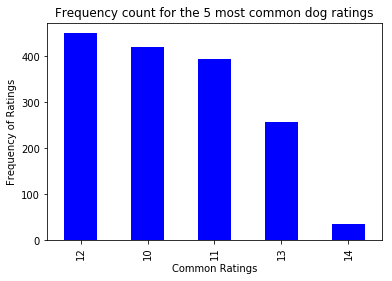

In [6]:
rating[:5].plot.bar(color='blue')

plt.xlabel('Common Ratings')
plt.ylabel('Frequency of Ratings')
plt.title('Frequency count for the 5 most common dog ratings')

# Show the plot
plt.show()

### Insight:

From the bar plot above, we can see that the most common rating given by WeRateDogs is **12/10**, followed by **10/10** and **11/10**. 

### Most retweeted and favorited dog stage

Although most dog stages are null values in our data, we are still curious about the retweet and favorite count of each dog stage. Thus, we created an additional dataframe containing the `dog_stage`, `retweet_count`, and `favorite_count` with no null values. We used `groupby()` and `aggregate()` to group by dog stages and aggregate the dataframe using `max`.

In [59]:
# Create a dataframe without dog stage null values
dog_stages_data = twitter_archive_master.dropna()
dog_stages_data.shape

(262, 21)

In [60]:
dog_stages_data = dog_stages_data[['dog_stage', 'retweet_count', 'favorite_count']]
dog_stages_data.head()

,dog_stage,retweet_count,favorite_count
9,doggo,7711,32467
12,puppo,8538,38818
14,puppo,2321,15359
28,pupper,3316,21524
37,doggo,3128,20771


In [61]:
grouped = dog_stages_data.groupby('dog_stage')

In [62]:
agg_df = grouped.aggregate(max)
agg_df

,retweet_count,favorite_count
dog_stage,,
doggo,79515,131075
floofer,18497,33345
multiple,19196,47844
pupper,32883,106827
puppo,48265,132810


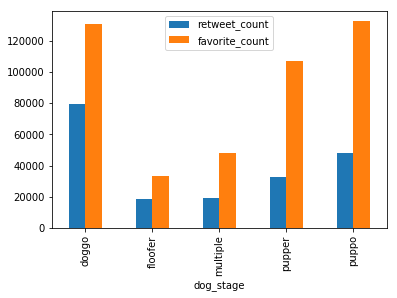

In [63]:
# plot the aggregated DataFrame as a bar plot
agg_df.plot.bar()

# show the plot
plt.show()

### Insight:

From the bar plot above, we can see that the dog stage with the maximum retweet count is `doggo`, followed by `puppo` then `pupper`. Also, we see that the favorite count is way more than the retweet count. The dog stage `puppo` had the maximum favourite count, followed by `doggo` then `pupper`. The dog stages with the smallest maximum retweet and favorite counts are `floofer` and `multiple`.

### Retweet Count Over time

We want to further investigate the retweet count by looking at the timestamp of tweets and the retweet count.

In [28]:
# Change the type of timestamp to datetime
twitter_archive_master.timestamp = pd.to_datetime(twitter_archive_master.timestamp) 

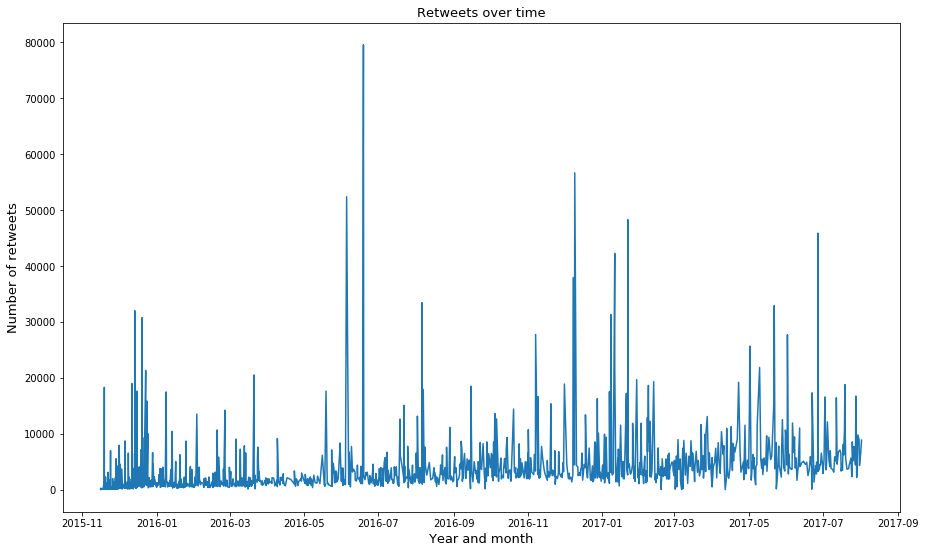

In [30]:
plt.subplots(figsize=(15, 9))
plt.plot(twitter_archive_master.timestamp, twitter_archive_master.retweet_count)
plt.title('Retweets over time', color = 'black', fontsize = '13')
plt.xlabel('Year and month', color = 'black', fontsize = '13')
plt.ylabel('Number of retweets', color = 'black', fontsize = '13');

### Insight:

From the plot above, we can see that peak with the most retweet count was in June 2016. Then, the retweet count dropped and reached its peak again in December 2016.